In [2]:
## imports 

# For testing detectron2 mask r-cnn with COCO 

import detectron2 

#Setup logger
from detectron2.utils.logger import setup_logger
setup_logger()

#Some common libraries 
import numpy as np 
import os,json,cv2,random 


#Detectron2 utilities 

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg 
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import sys 
sys.path.append(r"/Users/helenesemb/Documents/chipsogdip/kode")
from kode.dataset import load_damage_dicts


In [33]:
from detectron2.structures import BoxMode 


def find_contours(sub_mask):
    assert sub_mask is not None, "file could not be read, check with os.path.exists()"
    imgray = cv2.cvtColor(sub_mask, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours[0]


def create_image_annotation(file_name, width, height, image_id):
    return {
        "id": image_id,
        "width": width,
        "height": height,
        "file_name": file_name,
    }


def create_annotation_format(contour):
    return {
        "iscrowd": 0,
        "segmentation": [contour.flatten().tolist()],
        "bbox": cv2.boundingRect(contour),
        "bbox_mode": BoxMode.XYWH_ABS,
        "category_id": 0,
    }

In [3]:


%load_ext tensorboard 
%tensorboard --logdir /Volumes/helensem/Master/output/run1/resnet50

In [36]:
import skimage


def load_damage_dicts(dataset_dir, subset): 
    dataset_dicts = []

    assert subset in ["train", "val"]
    dataset_dir = os.path.join(dataset_dir, subset)
    image_ids = next(os.walk(dataset_dir))[1]
    for image_id in image_ids:

        image_dir = os.path.join(dataset_dir, image_id)
        (_, _, file_names) = next(os.walk(image_dir))
        file_name = file_names[0]
        image_path = os.path.join(image_dir, file_name)

        height, width = cv2.imread(image_path).shape[:2]
        record = create_image_annotation(image_path, width, height, image_id)

        mask_dir = os.path.join(image_dir, 'masks')
        objs = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith('.png') and ('corrosion' or 'grov_merking' in f):
                mask_path = os.path.join(mask_dir, f)
                mask = cv2.imread(mask_path)
                contour = find_contours(mask)
                obj = create_annotation_format(contour)
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


for d in ["train", "val"]:
    DatasetCatalog.register("damage_" + d, lambda d=d: load_damage_dicts(r"/Users/HeleneSemb/Documents/Master/chipsogdip", "train"))
    MetadataCatalog.get("damage_" + d).set(thing_classes=["damage"])

balloon_metadata = MetadataCatalog.get("damage_train")

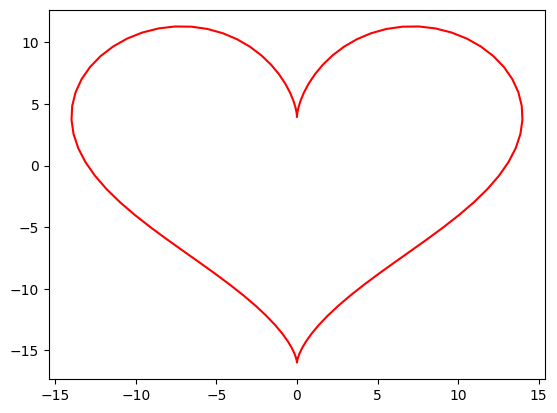

In [1]:
import numpy as np
from matplotlib import pyplot as plt
theta = np.linspace(0, 2 * np.pi, 100)
x = 14 * (np.sin(theta)**3)
y = 12 * np.cos(theta) - 5* np.cos(2*theta) - 2 * np.cos(3*theta) - np.cos(4*theta)
plt.plot(x, y, "r-")
plt.show()

In [9]:
balloon_metadata = MetadataCatalog.get("damage_train")

dataset_dicts = load_damage_dicts(r"/Users/HeleneSemb/Documents/Master", "train")
for d in random.sample(dataset_dicts, 1): 
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:,:,::-1], metadata = balloon_metadata, scale =0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("imageout", out.get_image()[:,:,::-1])
    cv2.waitKey(0)
    # closing all open windows
    cv2.destroyAllWindows()

Contour too small:  /Users/HeleneSemb/Documents/Master/train/0/masks/grov_merking_8.png
Contour too small:  /Users/HeleneSemb/Documents/Master/train/0/masks/grov_merking_9.png
Contour too small:  /Users/HeleneSemb/Documents/Master/train/0/masks/grov_merking_7.png
Contour too small:  /Users/HeleneSemb/Documents/Master/train/0/masks/grov_merking_6.png
Contour too small:  /Users/HeleneSemb/Documents/Master/train/0/masks/grov_merking_10.png
